In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time
import pylab
from data_parser_2 import insulin_correction

# Import meal data

In [123]:
#read data
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

# do insulin correction
from data_parser_2 import insulin_correction
insulin_correction(data)

data = data.loc[(data['meal'] == 0) & (data['meal_start'] == 0)]
data = data.reset_index(drop=True)
data.head()

,cgm,time_insulin,time_cgm,meal_start,meal
0,298.0,2017-07-25 13:25:09,2017-07-25 13:28:54,0,0
1,298.0,2017-07-25 13:25:09,2017-07-25 13:28:54,0,0
2,298.0,2017-07-25 13:25:18,2017-07-25 13:28:54,0,0
3,298.0,2017-07-25 13:25:20,2017-07-25 13:28:54,0,0
4,298.0,2017-07-25 13:25:21,2017-07-25 13:28:54,0,0


In [124]:
cgm = data['cgm'].to_numpy()

### plot the first 1000 points of the data

Text(0, 0.5, 'CGM values')

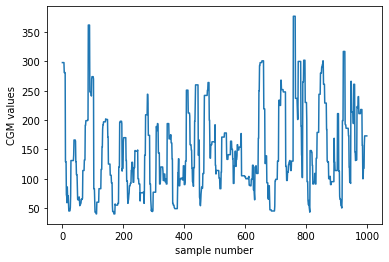

In [125]:
PLOT_POINTS = 1000
pylab.plot(cgm[:PLOT_POINTS])
pylab.xlabel('sample number')
pylab.ylabel('CGM values')

### ACF to compute Movind average (MA) parameters

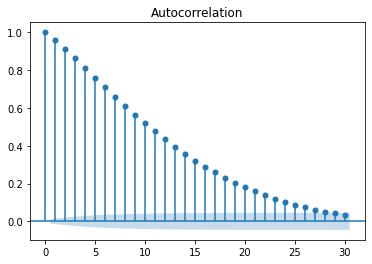

In [126]:
t1 = plot_acf(cgm, lags=30)

### PACF to compute Autoregression (AR) parameters

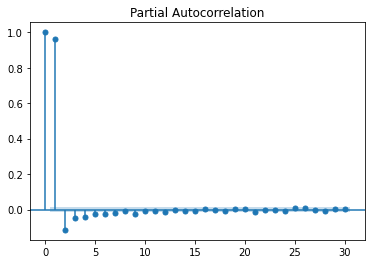

In [127]:
t1 = plot_pacf(cgm, lags=30)

### Fit the SARIMA Model

In [138]:
TRAIN_POINTS = 10000
train_data = cgm[:TRAIN_POINTS]
order = (10,0,30)

# we ingored seasonality as it gave bad results and increased compuation time
seasonal_order = (1, 0, 1, 400)
# define model
# model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model = SARIMAX(train_data, order=order)

#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

#summary of the model
print(model_fit.summary())

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model Fitting Time: 402.25400137901306
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:             SARIMAX(10, 0, 30)   Log Likelihood              -42668.418
Date:                Sat, 28 Nov 2020   AIC                          85418.836
Time:                        21:53:22   BIC                          85714.460
Sample:                             0   HQIC                         85518.903
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6865      0.438      1.566      0.117      -0.173       1.545
ar.L2         -0.7571      0.474     -1.596      0.110      -1.687       0.173
ar.L3        

### For Time-series data, one can only make predictions for few samples ahead in time

In [139]:
FORECAST_POINTS = 25
test_data = cgm[TRAIN_POINTS + 1 : TRAIN_POINTS + FORECAST_POINTS + 1]

#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
# predictions = model_fit.predict(2000, 2020)
predictions = np.array(predictions)
residuals = test_data - predictions

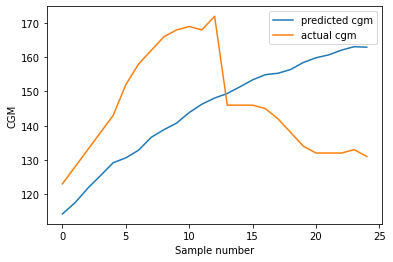

In [140]:
pylab.plot(predictions, label='predicted cgm')
pylab.plot(test_data, label='actual cgm')
pylab.xlabel('Sample number')
pylab.ylabel('CGM')
pylab.legend()

In [136]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.1241
Root Mean Squared Error: 20.392861811040287


#### Temporary code

In [84]:
import statsmodels.api as sm

In [85]:
training_mod = sm.tsa.SARIMAX(train_data, order=(5,0,20))
training_res = training_mod.fit()

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [89]:
training_mod_predictions = training_res.predict()

In [102]:
NEW_FORECAST_POINTS = 10
new_train_data = cgm[0 : TRAIN_POINTS + FORECAST_POINTS + 1 - NEW_FORECAST_POINTS]
mod = sm.tsa.SARIMAX(new_train_data, order=(5,0,20))
res = mod.filter(training_res.params)
# insample = res.predict()
# T = len(dta.realgdp.ix['2000-01-01':])
# forecast_error = dta.realgdp.ix['2000-01-01':] - insample.ix['2000-01-01':]
# print(np.sqrt(np.sum(forecast_error**2) / T))

In [103]:
mod_predictions = res.forecast(NEW_FORECAST_POINTS)

In [105]:
test_data[-NEW_FORECAST_POINTS:]

array([258., 260., 265., 261., 250., 240., 232., 224., 217., 212.])

In [106]:
mod_predictions

array([256.89738056, 255.01440489, 251.73953563, 245.81800837,
       241.21206292, 235.02395613, 228.02173165, 221.8363735 ,
       216.20130346, 210.68777558])